4장. 고객의 행동을 예측하는 테크닉 

테크닉 31. 데이터를 읽어 들이고 확인하자. 

In [68]:
import pandas as pd 
uselog = pd.read_csv("use_log.csv")
uselog.isnull().sum() # null(결측치)이 얼마나 있는지 확인 

log_id         0
customer_id    0
usedate        0
dtype: int64

In [69]:
customer = pd.read_csv("customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

테크닉 32. 클러스터링으로 회원을 그룹화하자. 

In [70]:
# customer 데이터를 사용해서 회원 그룹화. 
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [71]:
# K-means(K-평균) 
# 전통적인 클러스터링 방법으로 변수 간의 거리를 기반으로 그룹화 
# 표준화 필요 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering) # 표준화

kmeans = KMeans(n_clusters = 4, random_state = 0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


<ipython-input-71-7d56389765a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"] = clusters.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


테크닉 33. 클러스터링 결과를 분석하자 

In [72]:
# 데이터 수 파악하기 

# 열의 이름이 mean, median, max, min, membership_period로 돼 있어 혼란스러우므로 
# 월평균값, 월중앙값, 월최댓값, 월최솟값, 회원 기간으로 변경하자 

customer_clustering.columns = ["월평균값", "월중앙값", "월최댓값", "월최솟값", "회원기간", "cluster"]
customer_clustering.groupby("cluster").count() # 클러스터로 묶어 개수 세기

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [73]:
# 그룹마다 평균값 구하기 

customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


테크닉 34. 클러스터링 결과를 가시화하자.

In [74]:
# 그림을 그려 확인해보자 

# 주성분 분석
from sklearn.decomposition import PCA
X = customer_clustering_sc 
pca = PCA(n_components = 2) # 모델 생성 
pca.fit(X)
x_pca = pca.transform(X) # 주성분 분석 실행 
pca_df = pd.DataFrame(x_pca) # 2차원으로 축소한 데이터를 pca_df에 저장 
pca_df["cluster"] = customer_clustering["cluster"]

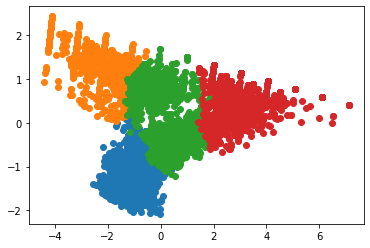

In [96]:
# # matplotlib을 이용해 가시화 
import matplotlib.pyplot as plt
# %matplotlib inline # 생략 가능. 웹에서는 없으면 뻑날 때가 많다. 
for i in customer_clustering["cluster"].unique(): # 그룹마다 색이 달라짐
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

테크닉 35. 클러스터링 결과를 바탕으로 탈퇴회원의 경향을 파악하자

In [76]:
# 클러스터링 결과를 이용한 탈퇴회원의 경향 파악하기 

# 지속회원과 탈퇴회원 집계해보기 (1이 탈퇴회원) 
customer_clustering = pd.concat([customer_clustering, customer], axis = 1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index = False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [77]:
# 정기적, 비정기적 여부 파악하기 (1이 정기적)
customer_clustering.groupby(["cluster", "routine_flg"], as_index = False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


테크닉 36. 다음 달의 이용 횟수 예측을 위해 데이터를 준비하자. 

In [78]:
# 이용 횟수 예측 모델 구축하기 

# 연월만 출력  
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["usedate"]

0        2018-04-01
1        2018-04-01
2        2018-04-01
3        2018-04-01
4        2018-04-01
            ...    
197423   2019-03-31
197424   2019-03-31
197425   2019-03-31
197426   2019-03-31
197427   2019-03-31
Name: usedate, Length: 197428, dtype: datetime64[ns]

In [79]:
# 연월 포맷 바꾸기 
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog["연월"]

0         201804
1         201804
2         201804
3         201804
4         201804
           ...  
197423    201903
197424    201903
197425    201903
197426    201903
197427    201903
Name: 연월, Length: 197428, dtype: object

In [80]:
# 뽑은 연월을 customer_id와 결합 
uselog_months = uselog.groupby(["연월", "customer_id"], as_index=False).count()
uselog_months

,연월,customer_id,log_id,usedate
0,201804,AS002855,4,4
1,201804,AS009013,2,2
2,201804,AS009373,3,3
3,201804,AS015315,6,6
4,201804,AS015739,7,7
...,...,...,...,...
36837,201903,TS995853,8,8
36838,201903,TS998593,8,8
36839,201903,TS999079,3,3
36840,201903,TS999231,6,6


In [81]:
# 이름 바꾸기 (log_id -> count), usedate 삭제
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7
...,...,...,...
36837,201903,TS995853,8
36838,201903,TS998593,8
36839,201903,TS999079,3
36840,201903,TS999231,6


In [82]:
# 이번달(19.03)부터 과거 5개월분(18.10~)의 이용횟수와 다음달의 이용횟수 분석하기
# count_0이 1개월 전. 
# 결측치는 가입 기간이 짧아서 데이터가 존재하지 않는 경우.
year_months = list(uselog_months["연월"].unique())
predict_data = pd.DataFrame() 
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["연월"] == year_months[i]]
    tmp.rename(columns = {"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["연월"] == year_months[i-j]]
        del tmp_before["연월"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on = "customer_id", how = "left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data

C:\Users\82109\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...
18305,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
18306,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


In [83]:
# 머신러닝을 진행하는 경우 결측치를 처리해야함. 
# dropna로 결측치가 있는 데이터 삭제 후 index 초기화 

predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data # 6개월 이상 재적 중인 회원만 남음 

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0
15109,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
15110,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


테크닉 37. 특징이 되는 변수를 추가하자 

In [84]:
# 회원 기간 추가하기 

predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on = "customer_id", how = "left")
predict_data

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01
...,...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0,2015-09-01
15109,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0,2018-09-01
15110,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0,2016-06-01
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01


In [85]:
# 연월과 start_date의 차이를 이용해 회원 기간을 월 단위로 작성하기 

predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format = "%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta 
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years * 12 + delta.months 
predict_data # period 열 추가 

<ipython-input-85-8d6daa59ea66>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years * 12 + delta.months


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12
...,...,...,...,...,...,...,...,...,...,...,...,...
15108,201903,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0,2015-09-01,2019-03-01,42
15109,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0,2018-09-01,2019-03-01,6
15110,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0,2016-06-01,2019-03-01,33
15111,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0,2017-03-01,2019-03-01,24


+) 회귀분석 이론과 예제

In [86]:
# 선형 회귀 분석(Linear Regression) 
# - 변수 A, B의 발생이 독립적이지 않고 관련성이 있으며 방향성도 있을 경우, 이 변수들의 인과관계를 토대로 수학적 함수로 가정하고 
# 측정된 자료를 이용해서 함수의 개수를 추정하여 예측하거나 통계분석을 수행하는 과정을 회귀분석이라고 한다. 

# 예를 들면 어떤 실험에서 시약 투입량에 따라 결과물 반응이 다르게 나타나고 관련성과 방향성이 파악되면 약의 투입량에 따른 
# 인과관계로 반응의 결과를 예측할 수 있다. 

# 시약의 투입량처럼 결과 반응에 영향을 주는 변수를 '독립변수'(Independant Variable: x), '설명변수', '예측변수' 등으로 부르고, 
# 반응 결과와 같은 변화되는 결과로 측정되는 변수를 '종속변수'(Dependant Varibale: y), '반응변수' 라고 부른다. 

# 이때, 이들 변수들 간의 관계가 선형이고 독립변수가 1개이면 '단순 선형회귀분석'이라고 한다. 
# 만일 독립변수가 2개 이상일 경우, 중회귀모형(Multiple Linear Regression, MLR)이라고 한다. 

In [87]:
# 간단한 선형회귀분석 
# 아이리스 데이터로 선형 회귀분석 실습 

from sklearn import datasets
dataset = datasets.load_iris()

In [88]:
data = dataset.data
data # 수치형 데이터(길이와 너비. 총 4개) 

# 독립변수 (수치형, 연속형)
# 꽃받침의 길이, 너비, 꽃잎의 길이, 너비 

# 종속변수 (범주형)
# Species 붓꽃의 종류 

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [89]:
targets = dataset.target
targets[:5] # 눈에 안들어오니 5개만 출력 

array([0, 0, 0, 0, 0])

In [90]:
# data는 의사결정나무의 독립변수를 사용하고 4개의 수치형 변수로 구성되어 있으며 
# target은 종속변수로 붓꽃의 종류를 나타낸다. (라벨 인코딩한 값) 
# 종속변수를 수치형으로 targets의 변수를 Petal Width로(꽃잎 너비) 바꾸고 
# data는 Petal Width를 제외하자. 

In [91]:
targets = data[:, 3] # Petal Width를 Target으로 넣기 
data = data[:, 0:3] # Petal Width를 제외 
targets

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1,
       0.1, 0.2, 0.4, 0.4, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.5, 0.2, 0.2,
       0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2,
       0.2, 0.3, 0.3, 0.2, 0.6, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 1.4, 1.5,
       1.5, 1.3, 1.5, 1.3, 1.6, 1. , 1.3, 1.4, 1. , 1.5, 1. , 1.4, 1.3,
       1.4, 1.5, 1. , 1.5, 1.1, 1.8, 1.3, 1.5, 1.2, 1.3, 1.4, 1.4, 1.7,
       1.5, 1. , 1.1, 1. , 1.2, 1.6, 1.5, 1.6, 1.5, 1.3, 1.3, 1.3, 1.2,
       1.4, 1.2, 1. , 1.3, 1.2, 1.3, 1.3, 1.1, 1.3, 2.5, 1.9, 2.1, 1.8,
       2.2, 2.1, 1.7, 1.8, 1.8, 2.5, 2. , 1.9, 2.1, 2. , 2.4, 2.3, 1.8,
       2.2, 2.3, 1.5, 2.3, 2. , 2. , 1.8, 2.1, 1.8, 1.8, 1.8, 2.1, 1.6,
       1.9, 2. , 2.2, 1.5, 1.4, 2.3, 2.4, 1.8, 1.8, 2.1, 2.4, 2.3, 1.9,
       2.3, 2.5, 2.3, 1.9, 2. , 2.3, 1.8])

In [92]:
# 교차검증을 실시하기 위해 학습 데이터와 테스트 데이터를 7:3으로 나누어 보자 
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=42)

In [93]:
# 이제 준비된 데이터 셋들로 선형회귀모형을 학습시키자 
from sklearn.linear_model import LinearRegression 
lr = LinearRegression()
lr.fit(X_train, y_train) 

LinearRegression()

In [97]:
print("회귀계수", lr.coef_)
print("회귀상수", lr.intercept_)
print("훈련셋의 결정계수", lr.score(X_train, y_train))
print("테스트의 결정계수", lr.score(X_test, y_test))

# 회귀 계수는 독립변수의 개수만큼 산출되었고, 회귀 상수는 1개가 산출되었다. 

회귀계수 [-0.25113971  0.25971605  0.54009078]
회귀상수 -0.16560909133062807
훈련셋의 결정계수 0.9347286537352799
테스트의 결정계수 0.9407619505985546


In [98]:
# 훈련 데이터의 예측값 
print(lr.predict(X_train))

[1.07477693 1.73387867 2.00271583 1.33241642 2.25571656 1.4244524
 2.26947643 1.63756521 0.21871167 2.24642833 1.29338614 0.16762609
 0.18981656 0.56667188 0.9884422  1.59988891 0.53812737 0.22198577
 0.32879569 1.39762316 0.24674914 1.45042401 2.50614438 0.26636671
 1.35289162 1.75263861 0.30005702 1.69913656 1.83347692 1.05929109
 1.68779315 2.07684951 1.21083255 0.40928341 0.95833886 1.79081125
 0.19188243 0.05789267 1.128786   1.63135692 0.21906227 1.85944853
 0.27186311 0.3518438  1.77619374 0.82314087 2.01113574 1.78324898
 2.0022088  1.97431707 1.26277577 0.23867983 0.12773818 1.59938188
 2.09782106 0.29440418 0.21871167 0.21064236 1.5479457  2.1597537
 0.31830992 1.87628834 2.3498184  0.18724366 1.59404191 1.41360534
 1.59696541 1.44593099 1.92066928 0.40464464 1.8231369  1.40019606
 1.78960302 0.96847404 1.33605181 1.56600444 0.00372715 1.41446297
 1.50478368 0.27443602 1.4215289  2.15681951 2.08733529 0.32466396
 1.00942444 2.08733529 1.93785969 0.29491122 1.981383   0.139081

In [ ]:
# 정리 
# 변수들의 인과관계를 토대로 수학적 함수를 가정하고 측정된 자료를 이용하여 함수의 계수를 추정하여 
# 특정 변수를 예측하거나 연구 목적에 맞는 통계 분석을 수행하는 과정을 회귀분석(linear regression)이라고 한다. 

# 변수들 간의 관계가 선형이고 독립변수가 1개이면 단순선형회귀분석, 
# 2개 이상이면 다중회귀분석 또는 중회귀분석이라고 한다. 

테크닉 38. 다음 달 이용 횟수를 예측하는 모델을 구축하자 

In [104]:
# 예측모델 구축하기 
# 선형회귀 모델을 사용 
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")] 

# 비교적 최근 신입 회원들만 추출(18년4월 이후 가입자)

In [105]:
from sklearn import linear_model # 선형회귀 호출
import sklearn.model_selection # 학습과 테스트 데이터 분리 
model = linear_model.LinearRegression() # 초기화 
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
# 예측에 사용할 변수 X 
y = predict_data["count_pred"]
# 예측할 목적 변수 y 

In [108]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
# 분할 비율을 직접 지정하지 않으면 75%, 25%로 분할 

In [109]:
model.fit(X_train, y_train)

LinearRegression()

In [110]:
# 정확도 검증 
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5988684137486516
0.6346839670500531


테크닉 39. 모델에 기여하는 변수를 확인하자.

In [111]:
# 설명 변수마다 기여하는 계수를 출력해보자
coef = pd.DataFrame({"featurn_names":X.columns, "coefficient":model.coef_})
coef

,featurn_names,coefficient
0,count_0,0.332618
1,count_1,0.196197
2,count_2,0.170476
3,count_3,0.177430
4,count_4,0.080607
5,count_5,0.048149
6,period,0.057082


테크닉 40. 다음 달의 이용 횟수를 예측하자. 

In [112]:
# 특정 회원 두 명의 다음 달 방문 횟수를 예측해 보자. 
# 1번 회원: 7, 8, 6, 4, 4, 3 (방문 횟수, 6개월 전부터 1개월 단위)
# 2번 회원: 6, 4, 3, 3, 2, 2 

x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [113]:
model.predict(x_pred)
# 1번 회원은 3.8회, 2번 회원은 1.9회로 예측 

array([3.77251817, 1.97416451])

In [114]:
# csv 저장해두기 
uselog_months.to_csv("use_log_months.csv", index=False)